#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.   
Требуется построить модель для такого предсказания.

Для этого нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.



In [1]:
!pip install lightgbm
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import urllib.request
import functools as fnc
import operator as opr

from sklearn.model_selection import train_test_split,TimeSeriesSplit,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error,r2_score

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

In [3]:
np.random.seed(499)
get_yandex = lambda fn: urllib.request.urlretrieve(f"https://code.s3.yandex.net/datasets/{fn}", f"datasets/{fn}" )

multiply = lambda array: fnc.reduce( opr.mul,array,1 )
rmse = lambda y,pr: mean_squared_error(y,pr,squared=False) 
rmse.__name__='RMSE'
def print_metrics( y,pr, metrics = [rmse,r2_score]):
    scores = {}
    outline = ""
    for metric in metrics:
        scores[metric.__name__]= metric(y,pr)
        outline += f"{metric.__name__}: {scores[metric.__name__]}\t" 
    print(outline)   

## Подготовка

In [4]:
try:
    get_yandex("taxi.csv")
    df = pd.read_csv('datasets/taxi.csv',parse_dates=[0],index_col=[0] )
except Exception as e:
    print(e)
    exit(1)


In [5]:
df.sort_index(inplace=True)

_Загрузить данные и выполнить их ресемплирование по одному часу._

In [6]:
df = df.resample('1H').sum()

In [7]:
df.info()
df.head(),df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


(                     num_orders
 datetime                       
 2018-03-01 00:00:00         124
 2018-03-01 01:00:00          85
 2018-03-01 02:00:00          71
 2018-03-01 03:00:00          66
 2018-03-01 04:00:00          43,
                      num_orders
 datetime                       
 2018-08-31 19:00:00         136
 2018-08-31 20:00:00         154
 2018-08-31 21:00:00         159
 2018-08-31 22:00:00         223
 2018-08-31 23:00:00         205)

## Анализ

#### Общий анализ 

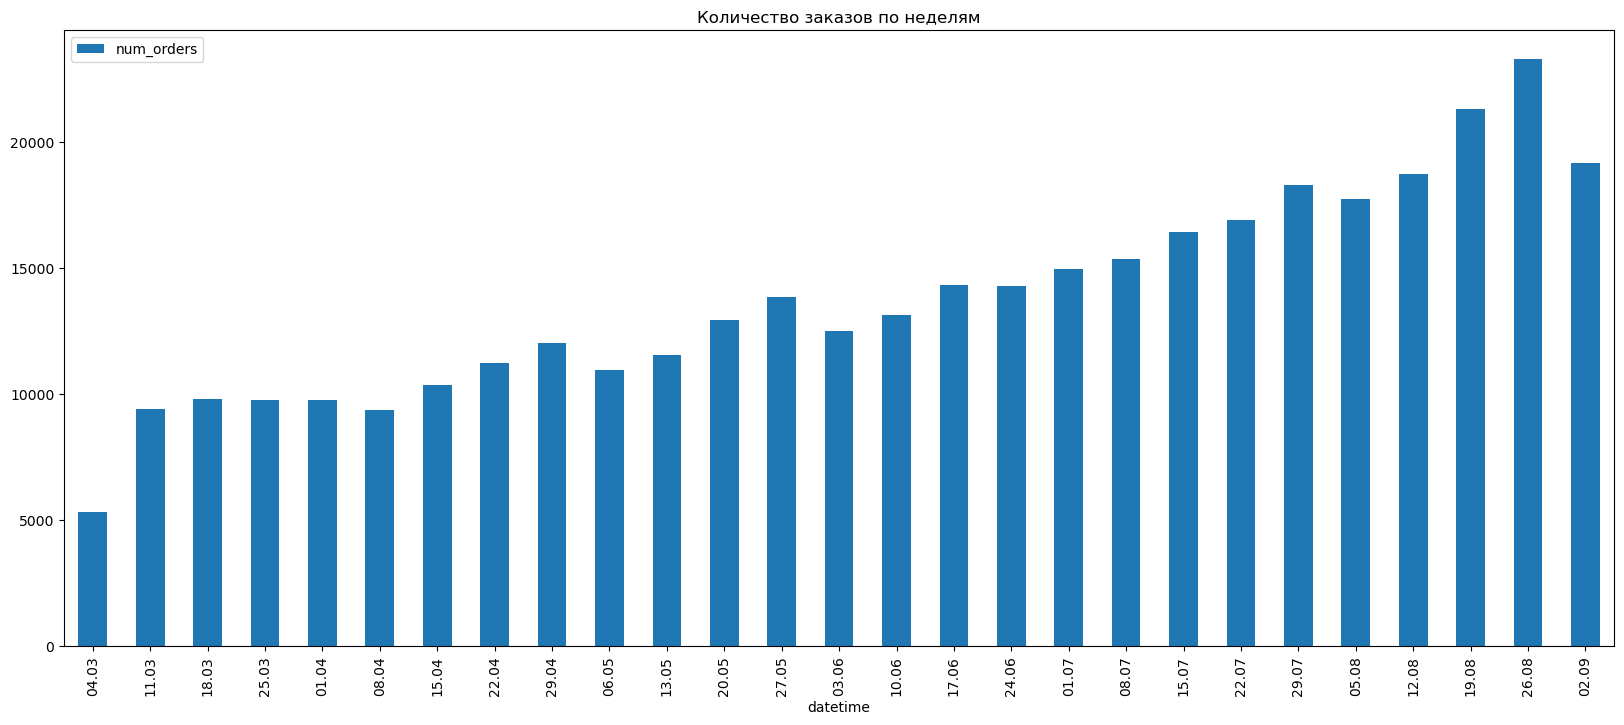

In [8]:
dw = df.resample('1W').sum()
dw.index = dw.index.strftime('%d.%m')
dw.plot.bar(figsize=(20,8),title='Количество заказов по неделям');

Слабо повышающийся тренд с ускорением в конце срока

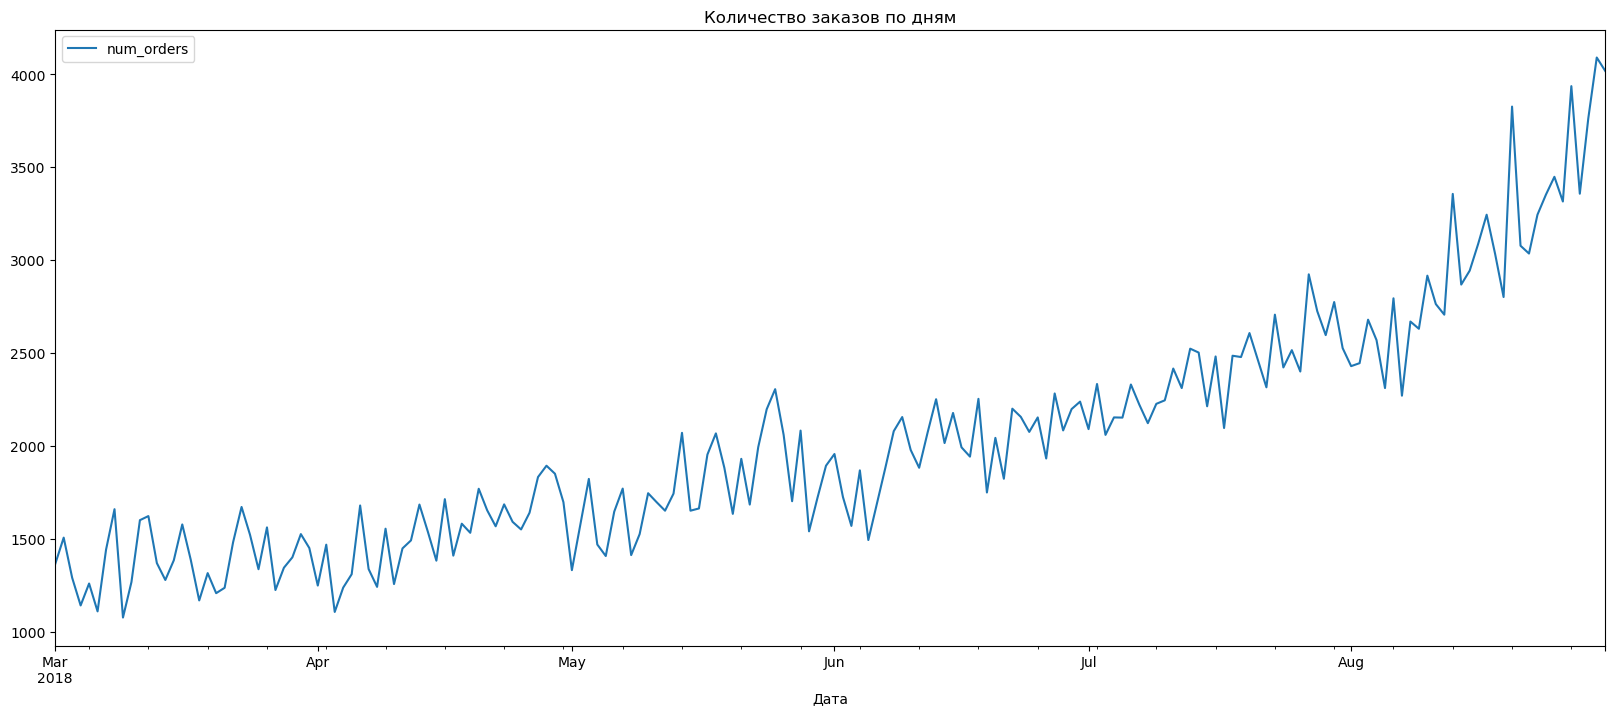

In [9]:
dd = df.resample('1D').sum()
dd.plot(figsize=(20,8),title ="Количество заказов по дням",xlabel='Дата');

Видны  серьезные колебания со дня на день

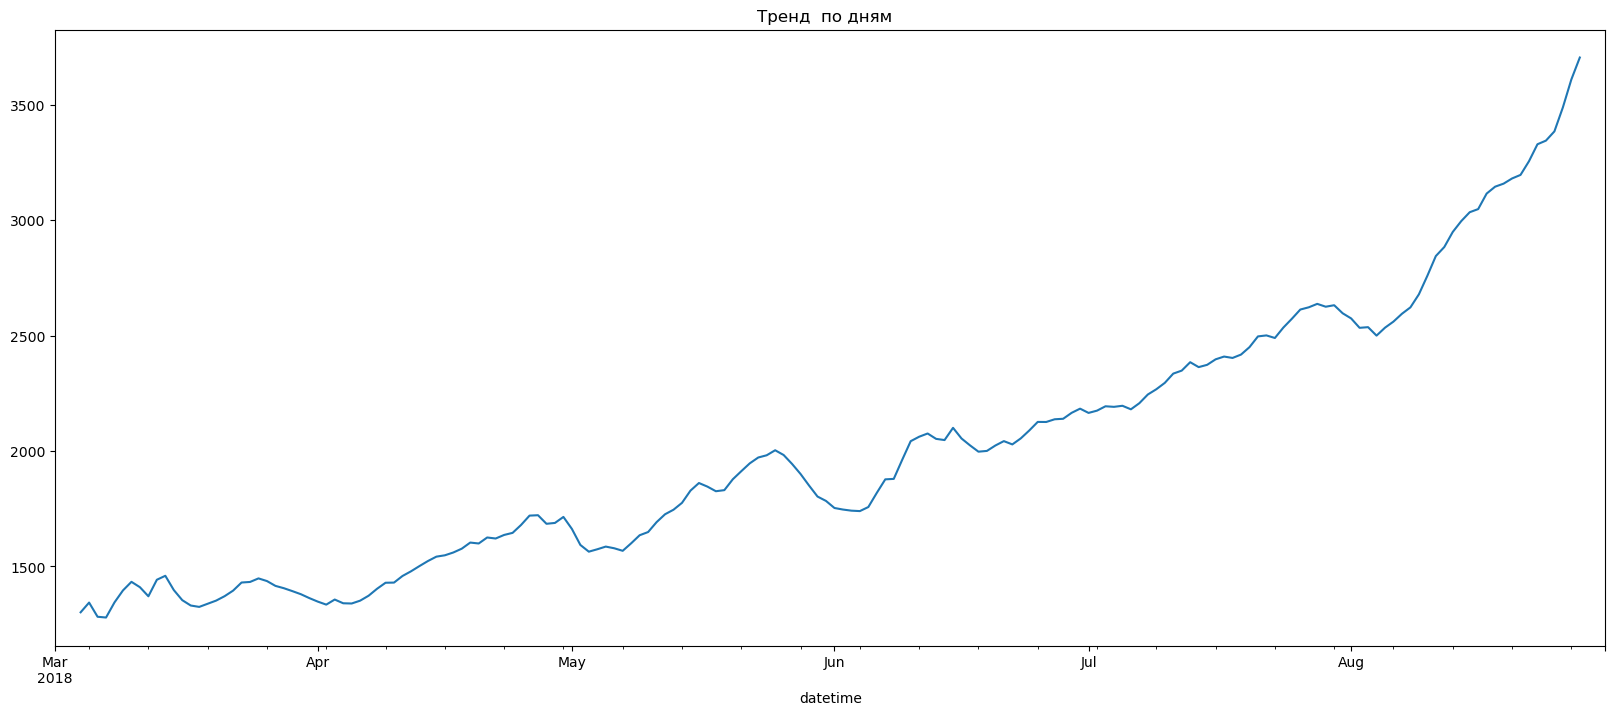

In [10]:
ddc = seasonal_decompose(dd)
ddc.trend.plot(figsize=(20,8),title='Тренд  по дням  ');

Тренд колчества заказов по дням  примерно соответствует недельному графику, видны слабые нерегулярные провалы . 

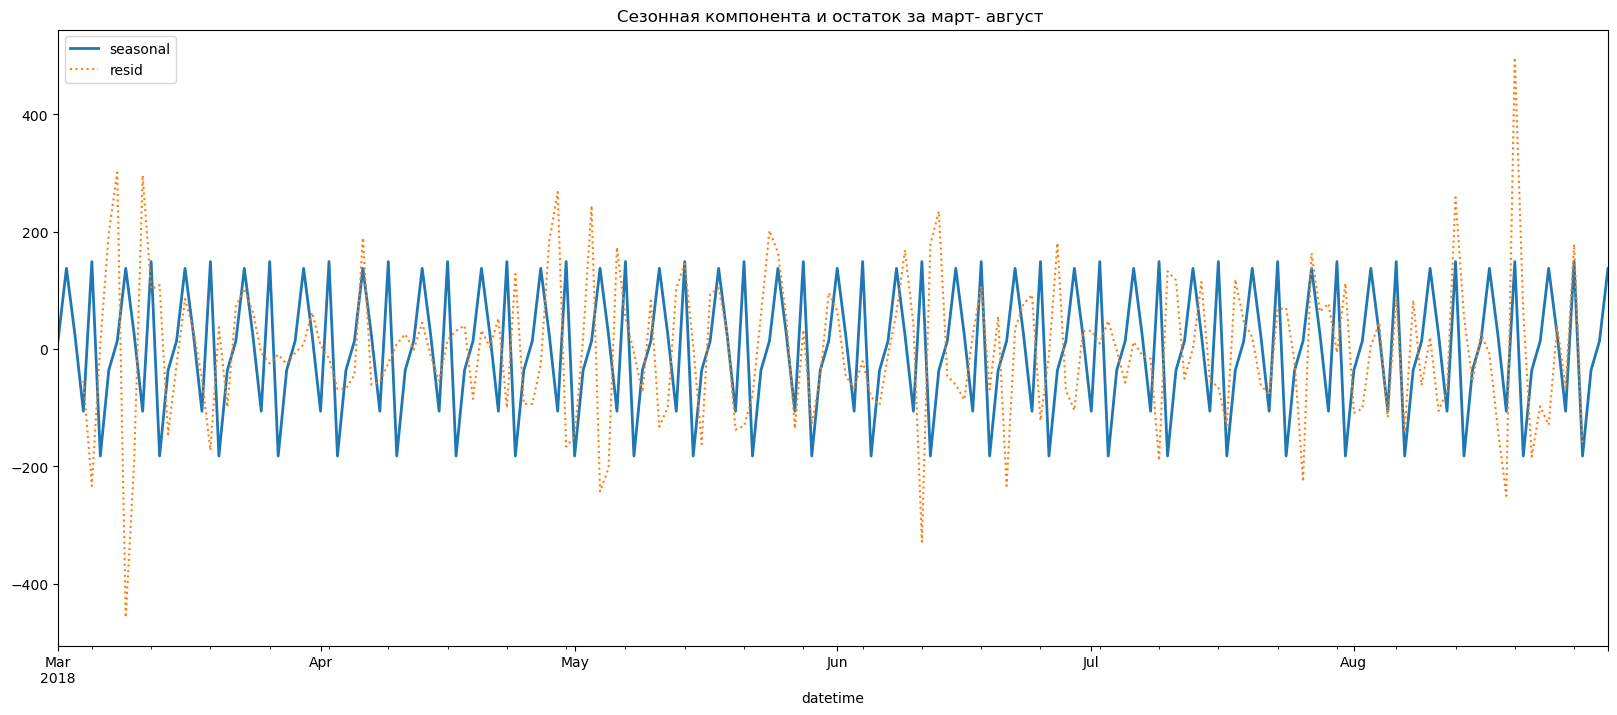

In [11]:
ddc.seasonal.plot(figsize=(20,8),lw=2);
ddc.resid.plot(figsize=(20,8),ls=':',title='Сезонная компонента и остаток за март- август ');
plt.legend();

Декомпозиция показывает по 2 пика в неделю со значительными колебаниями остатка, который может превышать ритмичные колебания.

####  Месячный анализ по дням

Более подробно посмотрим июль - предпоследний месяц,   
также это последний месяц, которй будет использован в пресказаниях и последний перед ускорением роста

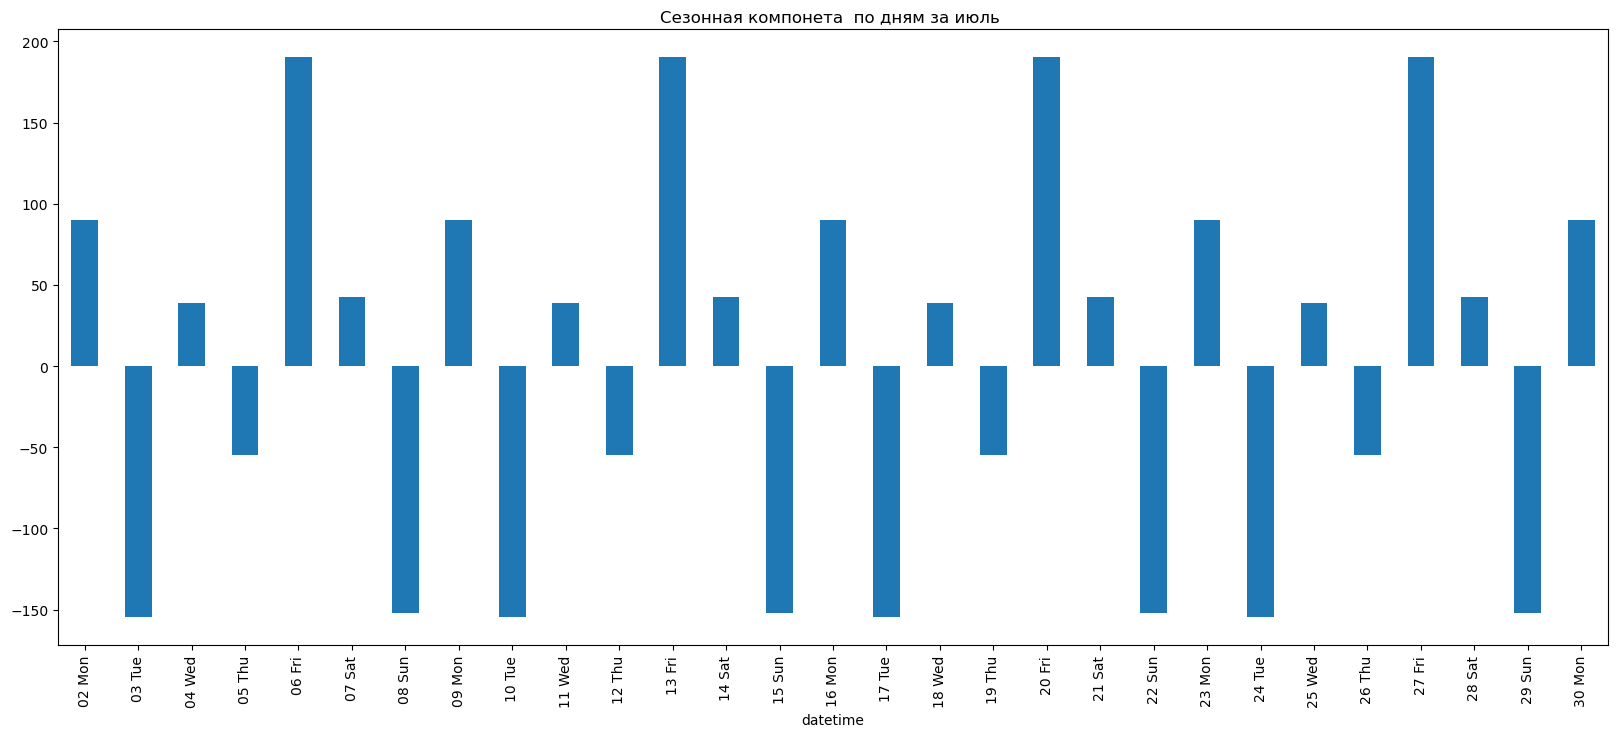

In [12]:
dm = seasonal_decompose( df['2018-07-02':'2018-07-30'].resample('1D').sum() )
dm_sr= pd.DataFrame( dm.seasonal).join( dm.resid )
dm_sr.index = dm_sr.index.strftime('%d %a')
dm_sr.seasonal.plot.bar(figsize=(20,8),title='Сезонная компонета  по дням за июль ');

В сезонной компоненте выделяются пики в пятницу и меньшие - в понедельник (какие-то "вахтовые" поездки? ) а также провалы в воскресенье и вторник

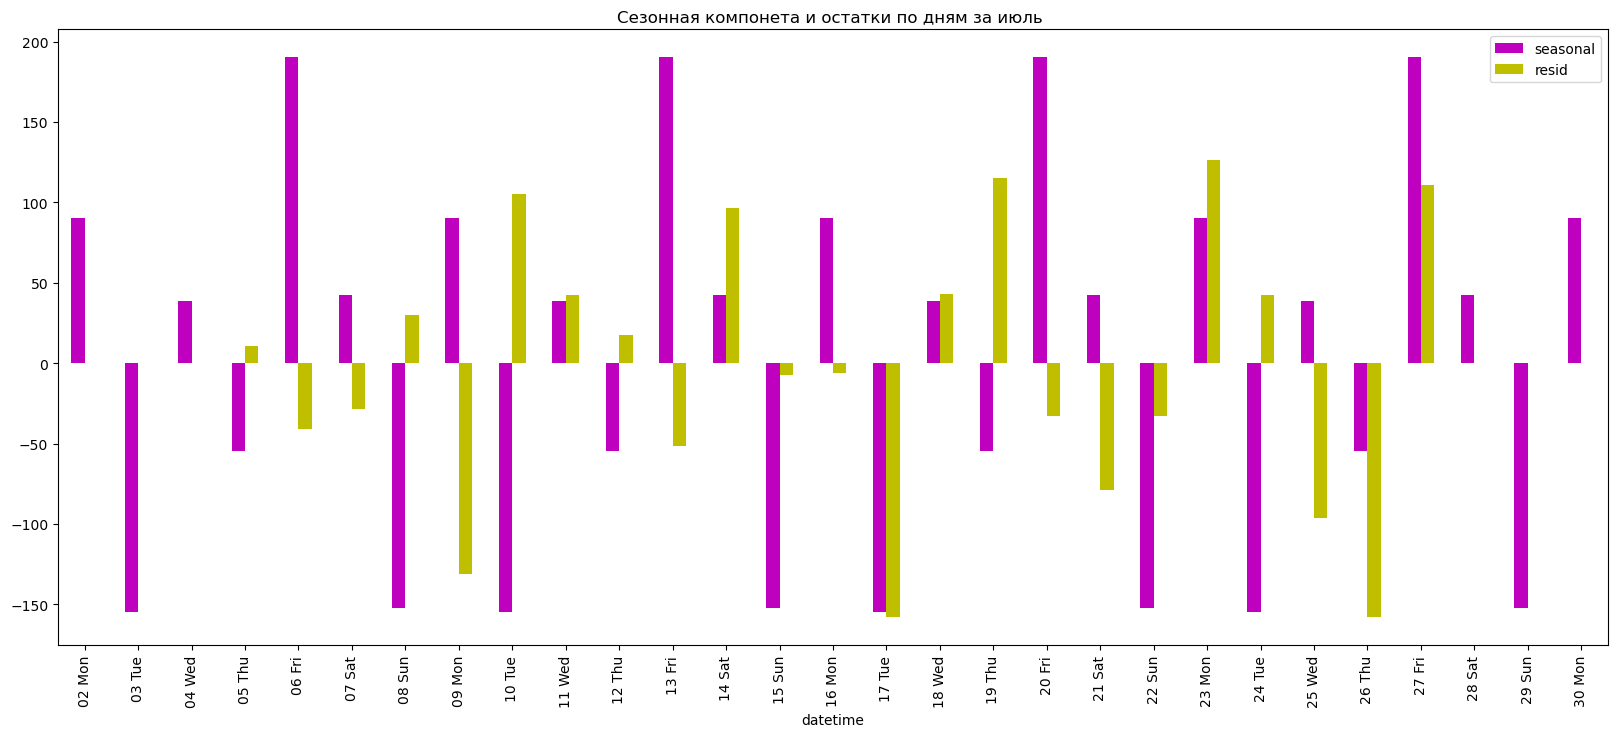

In [13]:
dm_sr.plot.bar(color=['m','y'],figsize=(20,8),title='Сезонная компонета и остатки по дням за июль ');


Остаток с сильными колебаниями, в частности можно отметить разнонаправленные колебания по вторникам и четвергам

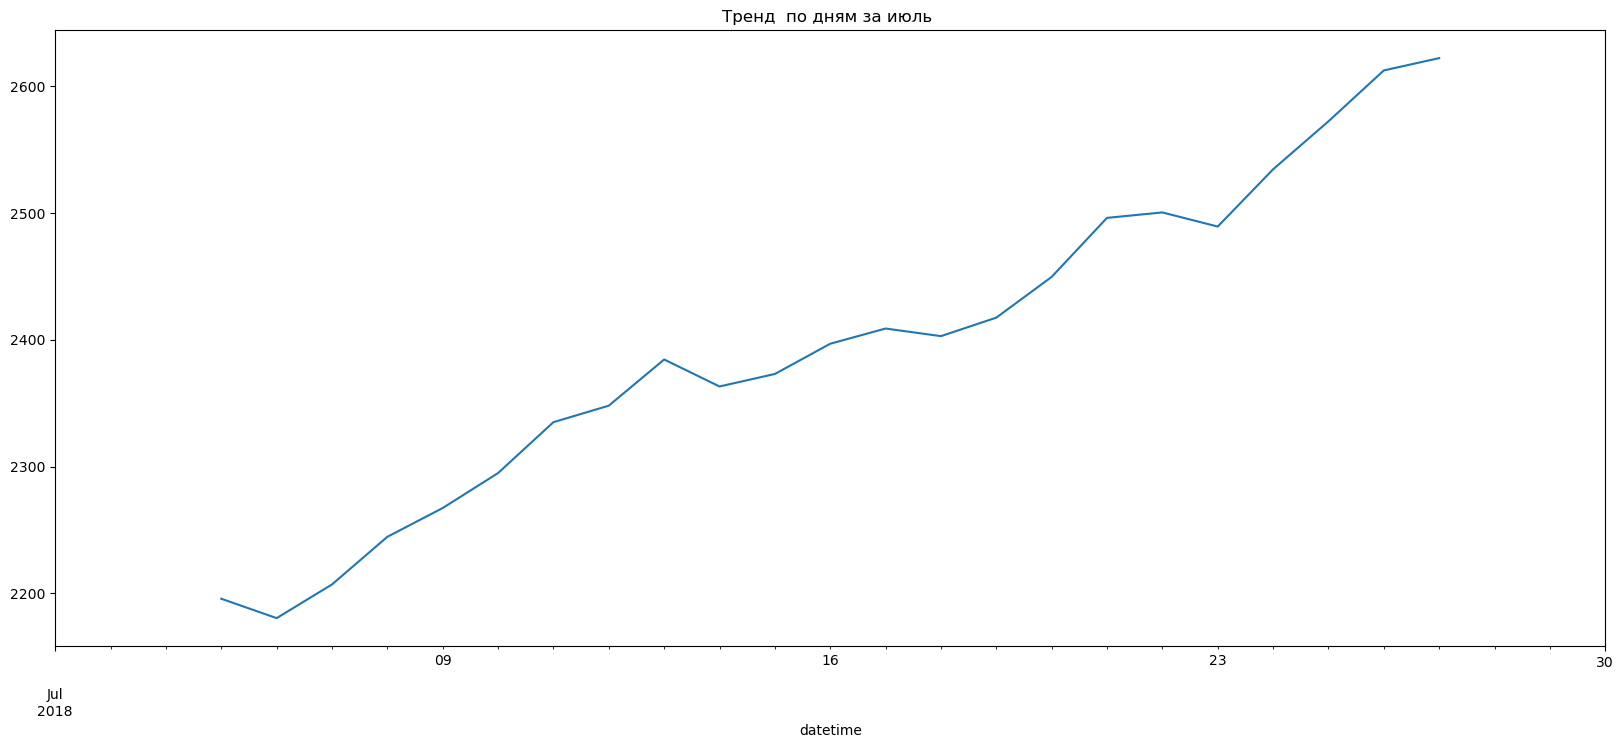

In [14]:
dm.trend.plot(figsize=(20,8),title='Тренд  по дням за июль ');

Тренд показывает мнотонный рост , примерно на 20% за месяц

#### Месячный анализ по дням за август

Изменилось ли что-то в данных за вагуст, которые надо предсказывать ?

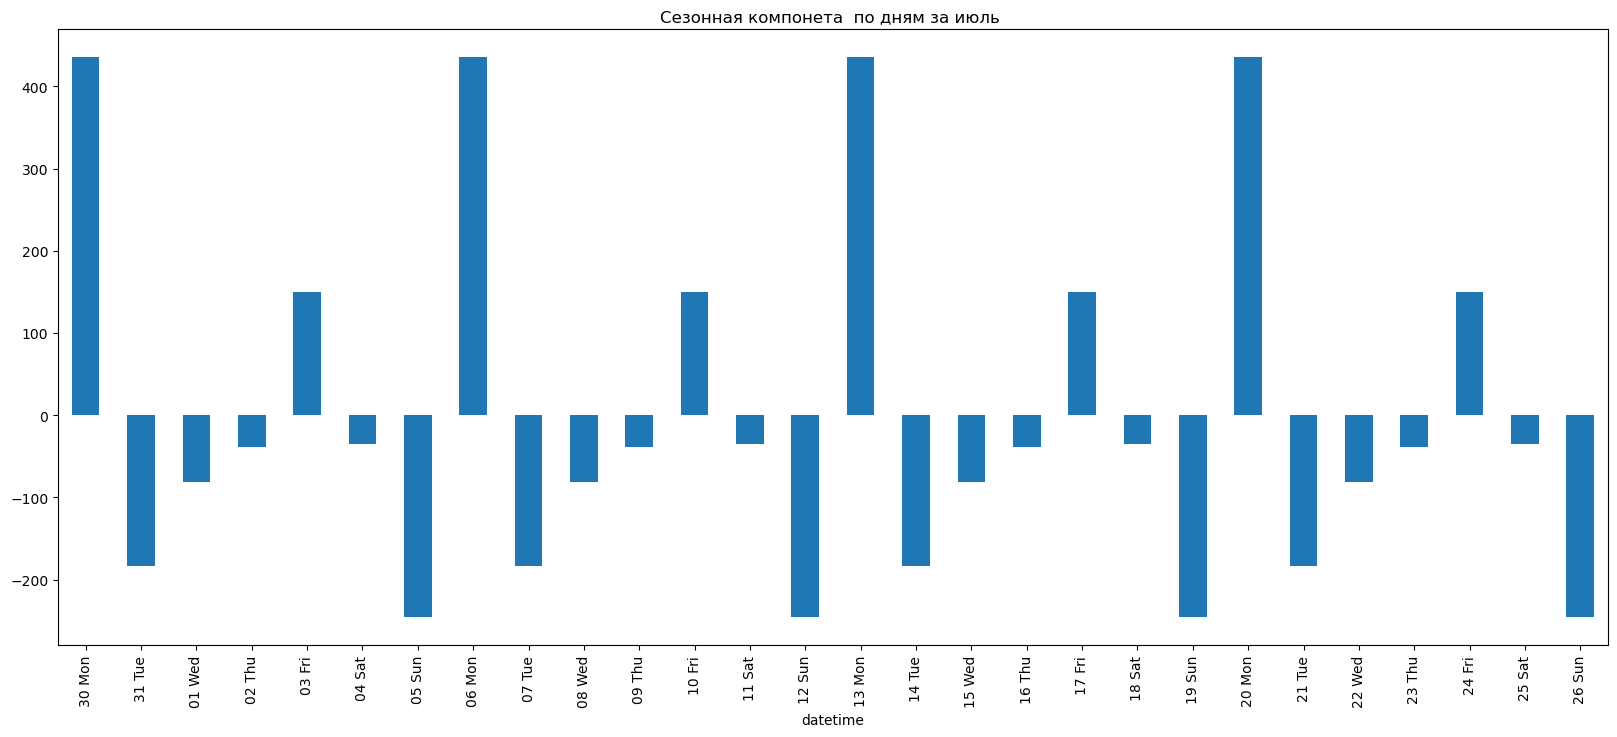

In [15]:
dm_a = seasonal_decompose( df['2018-07-30':'2018-08-26'].resample('1D').sum() )
dm_sr_a= pd.DataFrame( dm_a.seasonal).join( dm_a.resid )
dm_sr_a.index = dm_sr_a.index.strftime('%d %a')
dm_sr_a.seasonal.plot.bar(figsize=(20,8),title='Сезонная компонета  по дням за июль ');

Seasonal внешне изменился мало, но трафик по понедельникам вырос - и теперь он больше чем в пятницу.  
По другим дням отклонение от среднего  уровня не исзменилось, так что это именно увеличение числа заказов в понедельник. 

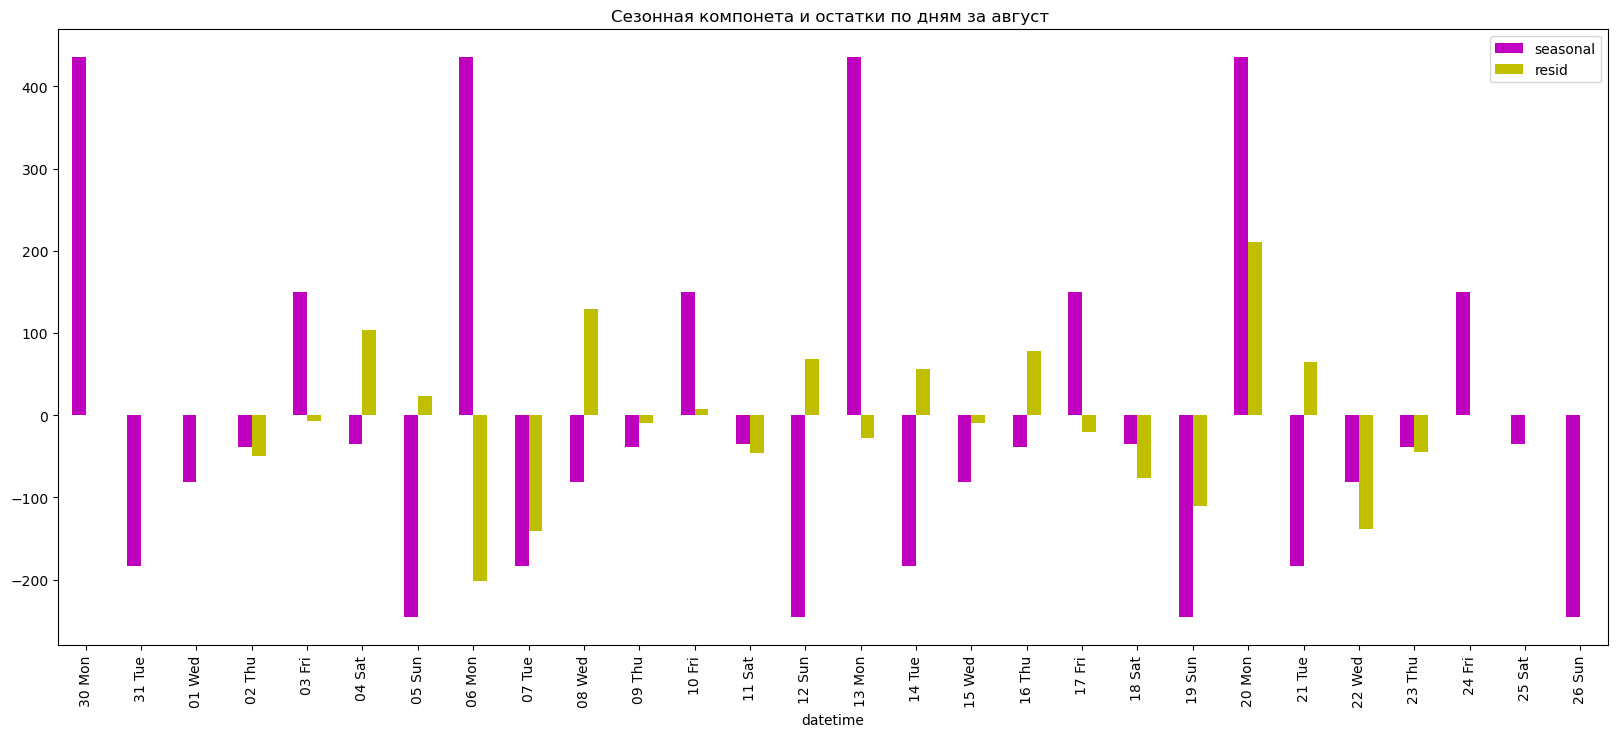

In [16]:
dm_sr_a.plot.bar(color=['m','y'],figsize=(20,8),title='Сезонная компонета и остатки по дням за август ');

Остатки меньше, чем в июле, график более стационарный

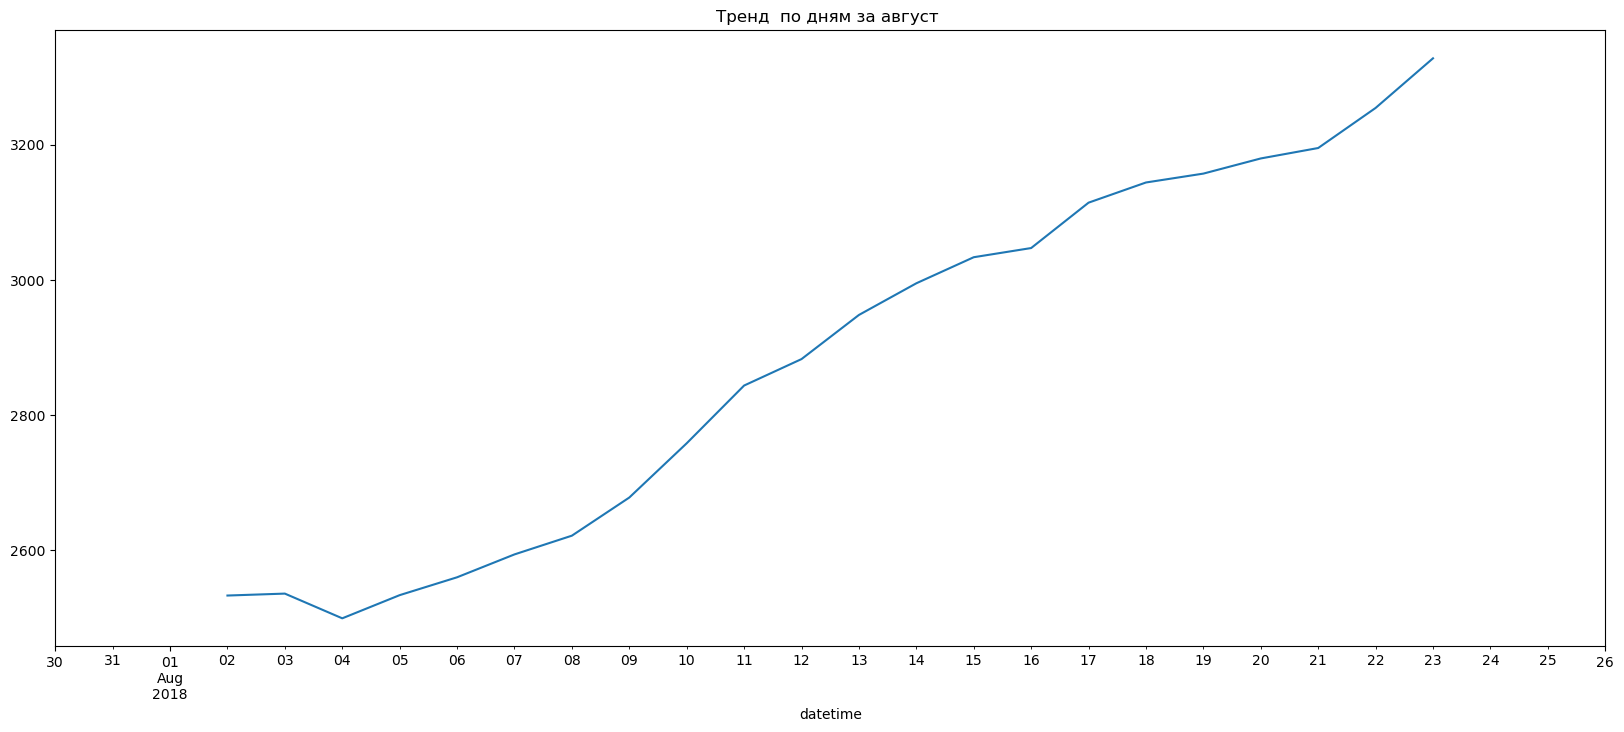

In [17]:
dm_a.trend.plot(figsize=(20,8),title='Тренд  по дням за август ');

Основное изменение в августовском трафике - появление нового источника заказов по понедельникам 

#### Недельный анализ по часам

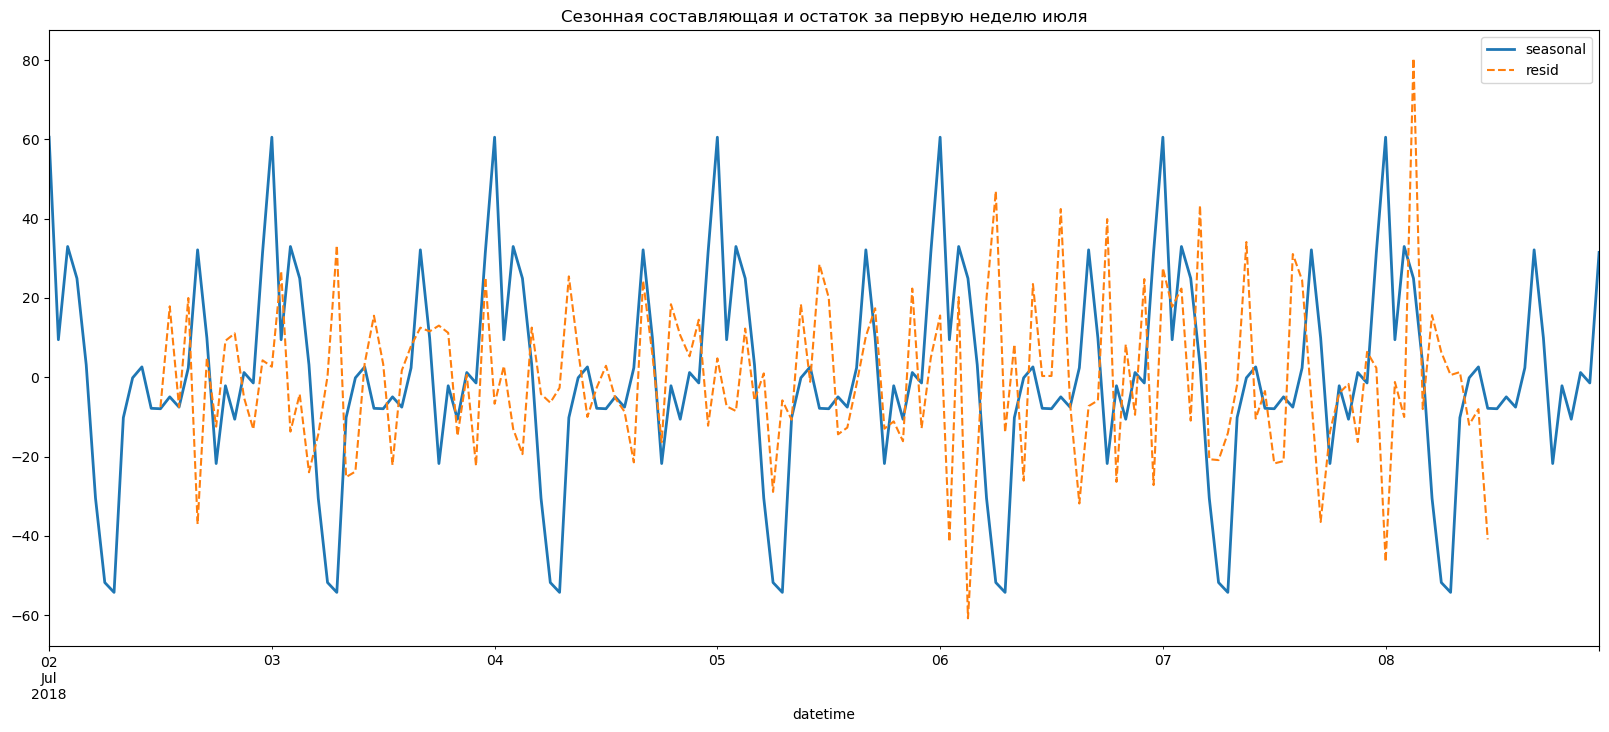

In [18]:
dh = seasonal_decompose(df['2018-07-02':'2018-07-08'])

dh.seasonal.plot(figsize=(20,8),lw=2,title='Сезонная составляющая и остаток за первую неделю июля' );
dh.resid.plot(figsize=(20,8),ls='--');
plt.legend();

По часам также есть сильные колебания, нельза выделить какой-ту особенную часть суток, количество заказов сильно меняются от часа к часу, со значительными нерегулярными остатками.  
Пики заказов на часы пик и полночь, минимумы - ночью

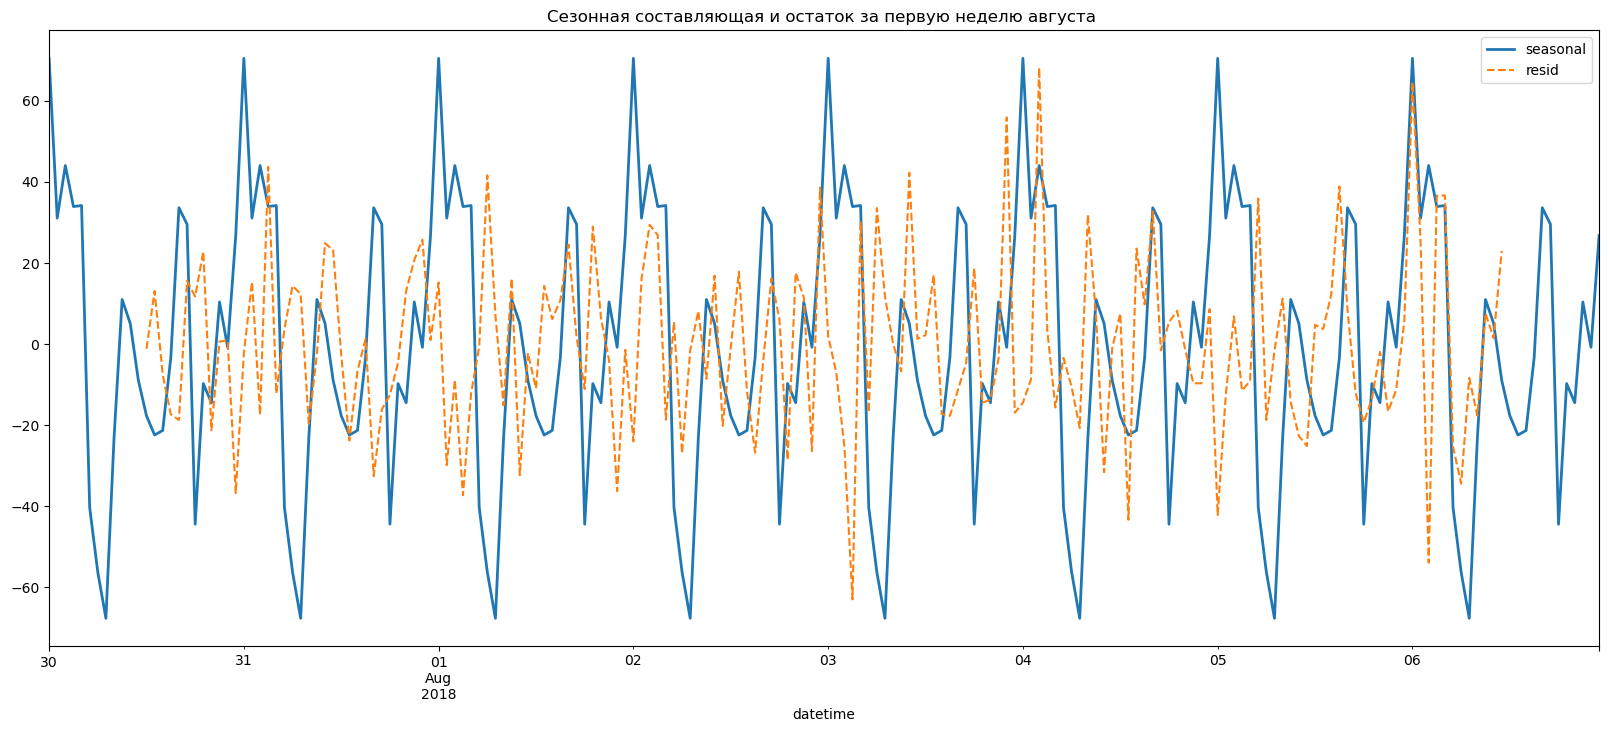

In [19]:
dh_a = seasonal_decompose(df['2018-07-30':'2018-08-06'])
dh_a.seasonal.plot(figsize=(20,8),lw=2,title='Сезонная составляющая и остаток за первую неделю августа ');
dh_a.resid.plot(figsize=(20,8),ls='--');
plt.legend();

По сравнению с июльским графиком есть небольшие  изменения -более плоский спад после получночи и плоский максимум в часы пик .   
Но понять , в какое время суток идёт увеличение заказов в понедльники, мне не удалось 

#### Разностный анализ

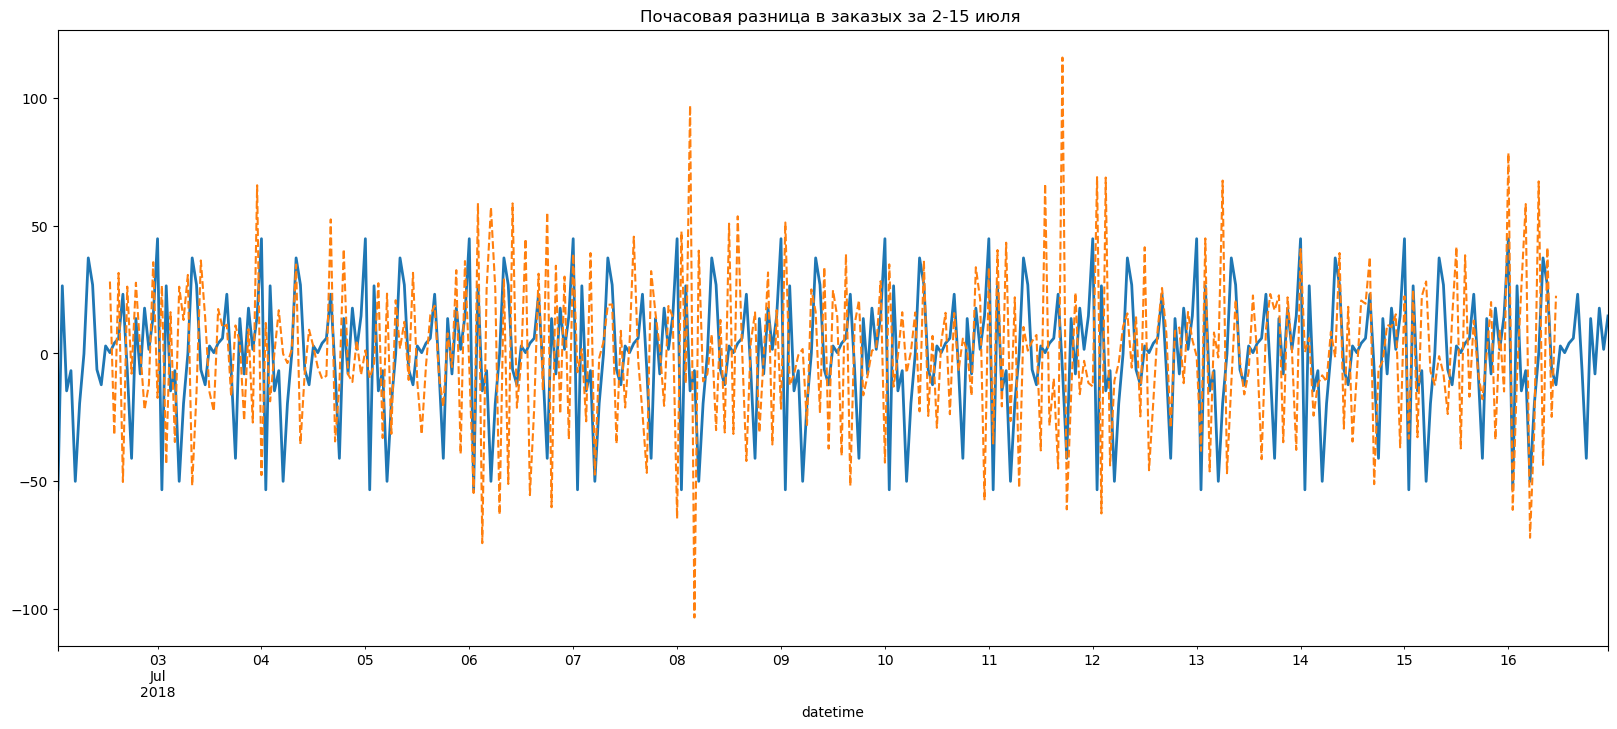

In [20]:
def plot_diff(dx,sf,title):
    dxc = seasonal_decompose( (dx-dx.shift(sf)).dropna() )
    dxc.seasonal.plot(figsize=(20,8),lw=2,title=title);
    dxc.resid.plot(figsize=(20,8),ls='--');
plot_diff(df['2018-07-02':'2018-07-16'],1, title='Почасовая разница в заказых за 2-15 июля ')                  

Почесовые разницы так же нестабильны, как и число заказов

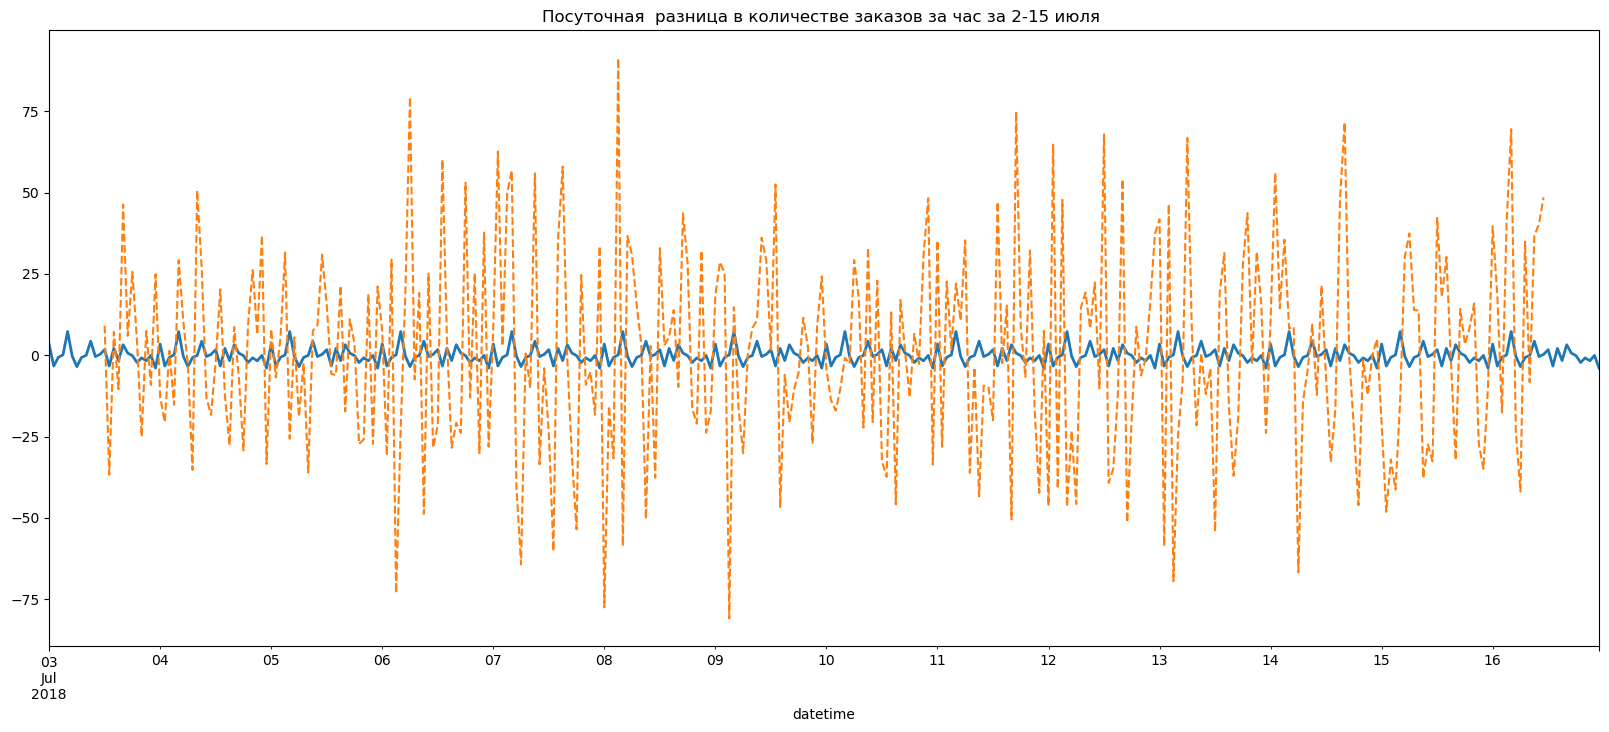

In [21]:
plot_diff(df['2018-07-02':'2018-07-16'],24, title='Поcуточная  разница в количестве заказов за час за 2-15 июля ')

Суточные разности выглядят намного более  стационарным процессом, чем исходное количество заказов 

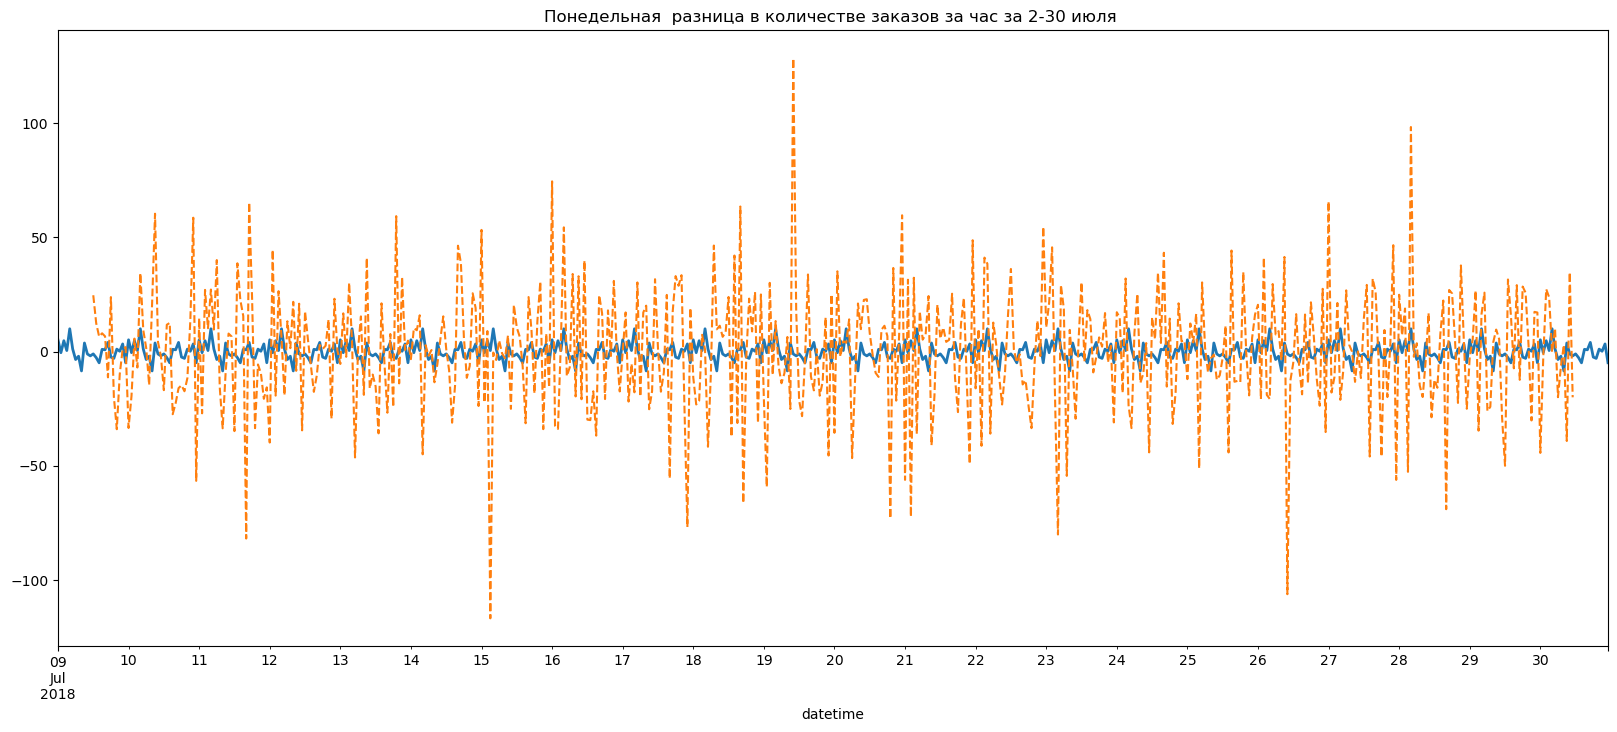

In [22]:
plot_diff(df['2018-07-02':'2018-07-30'],24*7, title='Понедельная  разница в количестве заказов за час за 2-30 июля ')

Также как и недельные разницы.   
**Основной вывод по резултатам анализа -  
 существование суточных  и недельных циклов количества заказов**

## Обучение

Так как есть выраженные периодические  колебания по дням недели и в течение суток, я ожидаю, что будет достаточно двуз признаков - час и день недели (категориальные) , а также для учета тренда - количество дней с начала года (числовой признак).
Но на всякий случай я добавлю сдвиги на дни и часы а также учет среднего за две недели.
В тестировании будут проверены оба варианта- с дополнительными признаками и без

#### Подготовка признаков

In [23]:
def split_date(d ):                    
    return d,d.dayofyear,d.day_name(),d.hour 

df = df.join( df.index.map(split_date).to_frame(name=['datetime','doy','day','hour']).set_index('datetime') )


In [24]:
for i in range(1,4):
    df["shift_"+str(i)] = df.num_orders.shift(i)
for i in [1,2,7]:
    df["shift_"+str(i*24)] = df.num_orders.shift(i*24)    
for i in [15]:     
    df['avg'+str(i)] = df.num_orders.shift().rolling(i).mean() 
df = df.dropna()    
df.info()
df.head()    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4248 non-null   int64  
 1   doy         4248 non-null   int64  
 2   day         4248 non-null   object 
 3   hour        4248 non-null   int64  
 4   shift_1     4248 non-null   float64
 5   shift_2     4248 non-null   float64
 6   shift_3     4248 non-null   float64
 7   shift_24    4248 non-null   float64
 8   shift_48    4248 non-null   float64
 9   shift_168   4248 non-null   float64
 10  avg15       4248 non-null   float64
dtypes: float64(7), int64(3), object(1)
memory usage: 398.2+ KB


,num_orders,doy,day,hour,shift_1,shift_2,shift_3,shift_24,shift_48,shift_168,avg15
datetime,,,,,,,,,,,
2018-03-08 00:00:00,143,67,Thursday,0,94.0,127.0,108.0,100.0,42.0,124.0,64.866667
2018-03-08 01:00:00,78,67,Thursday,1,143.0,94.0,127.0,121.0,75.0,85.0,71.066667
2018-03-08 02:00:00,65,67,Thursday,2,78.0,143.0,94.0,24.0,36.0,71.0,74.000000
2018-03-08 03:00:00,68,67,Thursday,3,65.0,78.0,143.0,66.0,49.0,66.0,74.466667
2018-03-08 04:00:00,60,67,Thursday,4,68.0,65.0,78.0,73.0,30.0,43.0,76.733333


In [25]:
df[['num_orders']].join( df.num_orders.shift().rolling(15).agg(['mean']) ).dropna().head(10)

,num_orders,mean
datetime,,
2018-03-08 15:00:00,78,61.600000
2018-03-08 16:00:00,96,57.266667
2018-03-08 17:00:00,41,58.466667
2018-03-08 18:00:00,81,56.866667
2018-03-08 19:00:00,72,57.733333
2018-03-08 20:00:00,114,58.533333
2018-03-08 21:00:00,86,65.733333
2018-03-08 22:00:00,88,71.066667
2018-03-08 23:00:00,79,75.666667


In [26]:
cat_cols = ['day','hour']
df[cat_cols]= df[cat_cols].astype('category')
# num_cols0 = ['doy']
num_cols = [ c for c in df.columns if df.dtypes[c] in ['int64','float64'] ]
print( cat_cols,num_cols)


['day', 'hour'] ['num_orders', 'doy', 'shift_1', 'shift_2', 'shift_3', 'shift_24', 'shift_48', 'shift_168', 'avg15']


#### Разбиение на тестовый и тренировочный набор 

При этом поддерживаются наборы Xs c сокращенным количеством признаков (без сконструированных со сдвигом и средним) 

In [27]:
y = 'num_orders'
X = [ c for c in num_cols + cat_cols if c != y ] 
Xs =  cat_cols +[ 'doy' ]


X_tr,X_te,y_tr,y_te= train_test_split(df[X],df[y], test_size=.1,shuffle= False)
Xs_tr = X_tr[Xs]
Xs_te = X_te[Xs]
print(X_tr.index.max(),X_te.index.min())


2018-08-14 06:00:00 2018-08-14 07:00:00


In [28]:
X_tr.head()

,doy,shift_1,shift_2,shift_3,shift_24,shift_48,shift_168,avg15,day,hour
datetime,,,,,,,,,,
2018-03-08 00:00:00,67,94.0,127.0,108.0,100.0,42.0,124.0,64.866667,Thursday,0
2018-03-08 01:00:00,67,143.0,94.0,127.0,121.0,75.0,85.0,71.066667,Thursday,1
2018-03-08 02:00:00,67,78.0,143.0,94.0,24.0,36.0,71.0,74.000000,Thursday,2
2018-03-08 03:00:00,67,65.0,78.0,143.0,66.0,49.0,66.0,74.466667,Thursday,3
2018-03-08 04:00:00,67,68.0,65.0,78.0,73.0,30.0,43.0,76.733333,Thursday,4


## Тестирование

Я использовал библиотеку классов из прошлых заданий с небольшими доработками. 
Она включает класс для разбора результата кроссвалидации, два класса рисования графиков и класс для интеграции теста  
ДЛя поиска оптимальных параметров на тренировочном наборе используется кроссвалидатор с разбиением временных рядов TimeTestSplit

####  ParsedResult

Класс разбора результата кроссвалидации, формирует 

In [29]:
class ParsedResult:
    def __init__(self,result,metric_name='score',sample_name='mean'):
        self.df = pd.DataFrame.from_dict( 
            { k:v for k,v in result.items() if k not in ['params']}
        )
# drop param_ prefix from column names for tidy display         
        self.primary_score=f"{sample_name}_test_{metric_name}"
        param_names = [ c for c in self.df.columns if c[:6]=='param_' ]        
        self.param_cols = [ c[6:] for c in param_names ]              
        self.df = self.df.rename( columns={ p:c for p,c in zip(param_names,self.param_cols) } )
# also drop model_ prefix which we use for model grid in pipeline   
        model_names = [ c for c in self.df.columns if c[:7]=='model__' ]
        self.param_cols = [c[7:]  if c[:7]=='model__' else c for c in self.param_cols ]
        self.model_cols = [ c[7:] for c in model_names ]   
        self.df = self.df.rename( columns={ p:c for p,c in zip(model_names,self.model_cols) } )
# select parameters, for which tested several values and arrange them descending (by number of differnt values)
        values_per_cols = list(zip( self.param_cols,[ len( np.unique( self.df[c].values ) ) for c in self.param_cols]))
        self.multi_value_cols =[it[0] for it in sorted(values_per_cols, key=lambda pair:pair[1],reverse=True) if it[1]>1 ]
# some object columns may be not string (f.e. lists)
        for i in range(len(self.df.columns)):
            if self.df.dtypes[i]=='object':
                self.df[self.df.columns[i]] = self.df[self.df.columns[i]].astype(str)
        
            
    def select(self, index,values=[],filters={},agg=[] ):
        values = [ [self.primary_score] ,values][bool(values)]
        if len(filters)>0 :
            condition = 'and'.join([ f" {k}=={v} " for k,v in filters.items() ]) 
            filtered = self.df.query(condition)    
        else:
            filtered = self.df
        cols = [ c for c in self.multi_value_cols if c not in list(filters.keys())+[index]+values ]      
        return(self.df.pivot_table(index=index,values=values,columns=cols)  )
     

#### ResultPlotter

Два класса для однородной отрисовки графиков :
Вспомогательный класс формирования аттрибутов линий для графиков, создаваемых в основном плоттере


In [30]:
class Styler:
    base_array=[]
    def __init__(self,param_array=[]):
        self.params = [ self.base_array,param_array][bool(param_array)]
    
    def key(self):
        pass
    
    def put(self,dct,index):
        dct[self.key()] = self.params[index]
        
class ColorStyler(Styler):
    base_array=[*'rgbykm']
    def key(self):
        return('color')

class DashStyler(Styler):
    base_array=['--',':','-.','-']
    def key(self):
        return('ls')
    
class WidthStyler(Styler):
    base_array=[ 2,4,7]
    def key(self):
        return('lw')

class AlphasStyler(Styler):
    base_array=[ .3,.9]
    def key(self):
        return('alpha')
    

И собственно плоттер, рисующий каждый столбец мультиколонки в своем стиле.   
Отельные непересекающиеся аттрибуты создаются для каждого уровня мультиколонки,   
в результате каждая элементарная подколонка получает уникальный стиль   

In [31]:
class ResultPlotter:
    base_params = {
        'colors':[*'rgbykm'],
        'styles':['--',':','-.','-',(0, (1, 10)),(0, (5, 10))],
        'widths':[ 2,4,7],
        'alphas':[.3,.8],
        'figsize': (20,8),
        'logscale':""
    }
    
    def __init__(self, test, params = {} ):
        self.model = test.model
        self.df= test.sel
        self.params=self.base_params | params
        self.stylers = [ColorStyler(self.params['colors']),DashStyler(self.params['styles']),
                        WidthStyler(self.params['widths']),AlphasStyler(self.params['alphas'])]
        self.mcols = self.df.columns      
        self.lev_names = list(self.mcols.names)
        self.num_levels= len(self.lev_names)
        self.level_sizes=[ len(set(self.mcols.get_level_values(x))) for x in self.lev_names]
        
        # if level 0("values of pivot") is one-valued, then start apply styles from columns 1  
        self.start_level = int(  self.level_sizes[0] == 1   )
# TODO: refactoring needed here, one or two new functions to encapsulate this feature
#       also to print short description for " result thread" 

        

# auxliary func to forms sequence of indexes for levels
# result is need index on the level  which may be one of color|dashstyle|linewidth
    def idx_on_level(self,idx, lev_num):
        items_on_hyperplane = multiply(self.level_sizes[(lev_num+1):]) 
        return idx//items_on_hyperplane% self.level_sizes[lev_num]
    
    def plot(self):
        fig,ax = plt.subplots(figsize=(20,6))
        if 'x' in self.params['logscale'].lower():
            ax.set_xscale('log')
        if not self.lev_names[0]:
            self.lev_names[0]='res.thread'
            
        for i_mcol in range(len( self.mcols)):
            graph_params = {}
            for i_level in range(self.start_level,self.num_levels):
                self.stylers[i_level-self.start_level].put( graph_params, self.idx_on_level(i_mcol,i_level) ) 
            idx=self.mcols[i_mcol]
            
            levels_for_label=[ f"{n}:{j} " for n,j in zip(self.lev_names[self.start_level:],idx[self.start_level:]) ] 
            graph_params['label'] = ','.join( levels_for_label )
            ax.plot(self.df[idx] ,**graph_params)
            ax.set_title(f"Тест {self.params['title']}")
            ax.set_xlabel('learning rate')
            ax.set_ylabel(f"{self.params['metric']}")
            ax.legend()

#### Класс для универсального теста на модели

Содержит программу стандартного теста

In [32]:
class TestModel:
    base_params = {
        'cv':4 ,
        'scoring' : ['neg_root_mean_squared_error','r2']
    }
    def __init__(self, model, params = {} ):
        self.model = model
        self.params = self.base_params | {'title':type(self.model).__name__} | params 
        
    def  __getattr__(self, k):
        if k in self.params:
            return ( self.params[k] )  
        
    def cross_validate(self,param_grid,X_tr,y_tr,refit=None):
        self.refit = [self.scoring[0],refit ][bool(refit)]
        self.gcv = GridSearchCV(self.model, param_grid,cv= self.cv, scoring=self.scoring,refit=self.refit) 
        self.gcv.fit(X_tr,y_tr)
        self.best = self.gcv.best_params_
        return self.best
    
    def check_best(self,X_tr,y_tr,X_te,y_te,metrics=[rmse,r2_score]):
        model = self.model.set_params(**self.best)
        model.fit(X_tr,y_tr)
        pr = model.predict(X_te)
        for metric in metrics:
            print(f"{metric.__name__}: {metric(y_te,pr)} \t")

    
    def parse_result(self,index_column='learning_rate',values=[]):
        self.res = ParsedResult(self.gcv.cv_results_,metric_name=self.refit)
        self.sel = self.res.select(index_column,values=values)
        return self.sel
        
    def plot(self):
        self.rp = ResultPlotter(self,{'logscale':'x','title':self.title,'metric':self.refit})
        self.rp.plot()

In [33]:
%%time
tscv = TimeSeriesSplit(10)
#tscv5 = TimeSeriesSplit(10,max_train_size =5)
                
debug_grid = {
    'iterations': [64,128],
    'learning_rate': [.1,.03,.01,.003]
}

test_grid = {
    'iterations': [64,128,256,512,1024],
    'learning_rate': [.6,.3,.1,.06,.03,.02,.01,.003]
}
param_grid = test_grid

CPU times: user 36 µs, sys: 8 µs, total: 44 µs
Wall time: 46.5 µs


#### Тест Catboost на полном наборе признаков  

In [34]:
%%time
cbst = TestModel(CatBoostRegressor(logging_level='Silent',cat_features=cat_cols),
              params=   {'cv': tscv,'title':'CatBoost full features set'} )
cbst.cross_validate(param_grid,X_tr,y_tr)

CPU times: user 5min 7s, sys: 52.3 s, total: 5min 59s
Wall time: 9min 15s


{'iterations': 256, 'learning_rate': 0.03}

Этот метод проверяет лучший результат на тестовом наборе 

In [35]:
cbst.check_best(X_tr,y_tr,X_te,y_te)

RMSE: 38.699099157431945 	
r2_score: 0.5682427864245017 	


 на тестовом наборе достигнута <b> метрика RMSE 38.7  </b>

 В принципе, этого  достаточно, так как требуется 48   
 Посмотрим что получается при различных вариантов гиперпараметров

In [36]:
cbst.parse_result()

mean_test_neg_root_mean_squared_error                        \
iterations                                     1024        128        256   
learning_rate                                                               
0.003                                    -22.255717 -32.959072 -29.079928   
0.01                                     -21.673625 -25.542088 -22.634498   
0.02                                     -22.105171 -22.509608 -21.658657   
0.03                                     -22.579692 -21.888247 -21.583237   
0.06                                     -23.084976 -21.823412 -22.111016   
0.1                                      -23.483860 -22.291814 -22.599952   
0.3                                      -23.994626 -23.385362 -23.589097   
0.6                                      -26.880945 -25.758297 -26.536049   

                                     
iterations           512         64  
learning_rate                        
0.003         -24.751163 -35.844123  
0.01          -21.643506 -29.972156  
0.02          -21.634094 -25.449936  
0.03          -21.990333 -23.481433  
0.06          -22.619853 -22.001758  
0.1           -23.108787 -21.863587  
0.3           -23.917684 -22.778242  
0.6           -26.838573 -24.905237

In [37]:
cbst.sel.columns

MultiIndex([('mean_test_neg_root_mean_squared_error', '1024'),
            ('mean_test_neg_root_mean_squared_error',  '128'),
            ('mean_test_neg_root_mean_squared_error',  '256'),
            ('mean_test_neg_root_mean_squared_error',  '512'),
            ('mean_test_neg_root_mean_squared_error',   '64')],
           names=[None, 'iterations'])

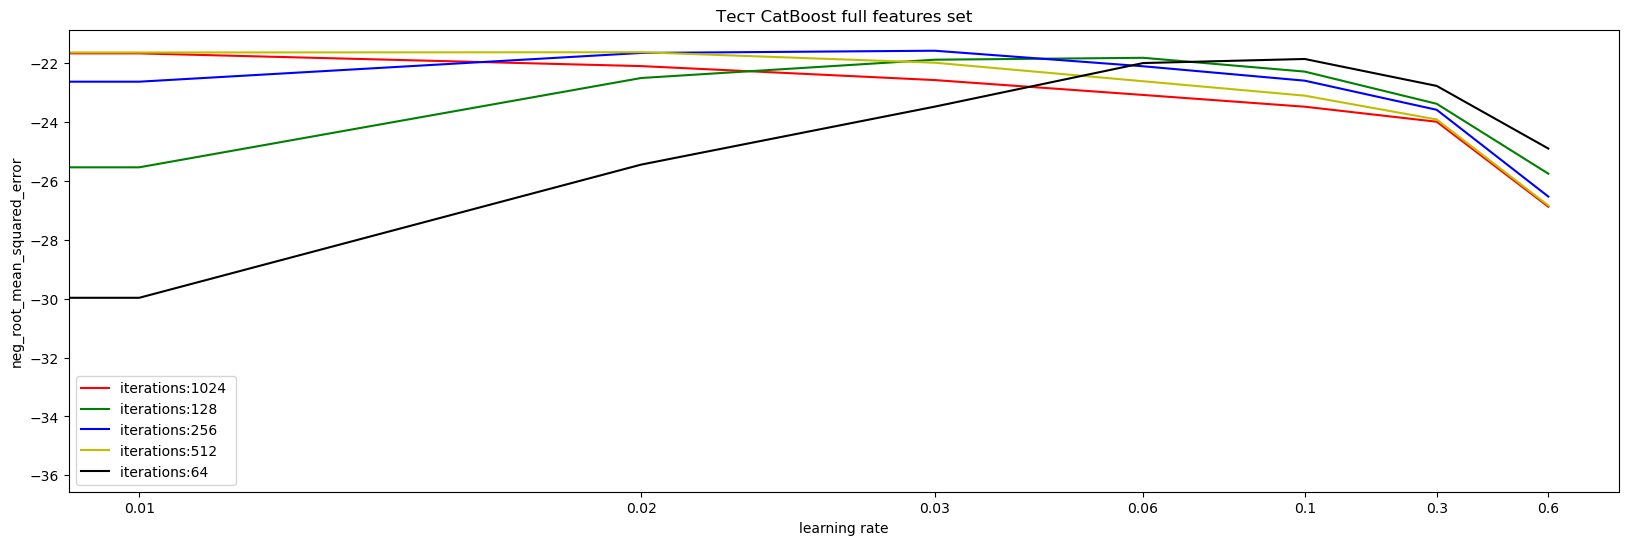

In [38]:
cbst.plot()

Максимумы достигаются при скорости 0.02-.01 в зависимости от числа оценщиков   
Результаты вглядят стабильно без резких колебаний  а приизменение и скоростей в ту или другую сторону начинается пере- или недо- обучение  
Однако заметно серьезное отличие средней  метрики тестов(mean_test_score) от  результата финального теста    

Поэтому отдельно выберем результаты последних серий и посмотрим метрику для них

In [39]:
cbst.parse_result(values=['mean_test_neg_root_mean_squared_error',
                          'split6_test_neg_root_mean_squared_error',
                          'split8_test_neg_root_mean_squared_error',
                          'split9_test_neg_root_mean_squared_error'])

mean_test_neg_root_mean_squared_error                        \
iterations                                     1024        128        256   
learning_rate                                                               
0.003                                    -22.255717 -32.959072 -29.079928   
0.01                                     -21.673625 -25.542088 -22.634498   
0.02                                     -22.105171 -22.509608 -21.658657   
0.03                                     -22.579692 -21.888247 -21.583237   
0.06                                     -23.084976 -21.823412 -22.111016   
0.1                                      -23.483860 -22.291814 -22.599952   
0.3                                      -23.994626 -23.385362 -23.589097   
0.6                                      -26.880945 -25.758297 -26.536049   

                                    split6_test_neg_root_mean_squared_error  \
iterations           512         64                                    1024   
learning_rate                                                                 
0.003         -24.751163 -35.844123                              -20.560582   
0.01          -21.643506 -29.972156                              -20.613562   
0.02          -21.634094 -25.449936                              -21.101510   
0.03          -21.990333 -23.481433                              -21.472532   
0.06          -22.619853 -22.001758                              -22.331752   
0.1           -23.108787 -21.863587                              -23.021372   
0.3           -23.917684 -22.778242                              -24.091205   
0.6           -26.838573 -24.905237                              -26.181498   

                                                           \
iterations           128        256        512         64   
learning_rate                                               
0.003         -30.478565 -26.393232 -22.266632 -33.509831   
0.01          -23.367419 -20.782965 -20.459511 -27.471269   
0.02          -20.826414 -20.471277 -20.678743 -23.237200   
0.03          -20.626900 -20.410486 -20.760583 -21.749512   
0.06          -20.925294 -21.013209 -21.665647 -20.889651   
0.1           -21.079052 -21.707223 -22.429026 -20.712313   
0.3           -22.761392 -23.252621 -23.761957 -21.633495   
0.6           -23.593165 -25.835685 -26.161628 -22.930336   

              split8_test_neg_root_mean_squared_error                        \
iterations                                       1024        128        256   
learning_rate                                                                 
0.003                                      -26.808282 -42.051184 -37.022764   
0.01                                       -24.957750 -31.532218 -27.461081   
0.02                                       -26.055708 -26.929471 -25.507677   
0.03                                       -27.038740 -25.761683 -25.025473   
0.06                                       -27.555770 -25.166351 -25.544347   
0.1                                        -28.406409 -25.652651 -27.006663   
0.3                                        -27.397920 -27.755273 -27.227272   
0.6                                        -35.368217 -28.842260 -34.089365   

                                    split9_test_neg_root_mean_squared_error  \
iterations           512         64                                    1024   
learning_rate                                                                 
0.003         -30.891925 -45.980134                              -31.758344   
0.01          -25.455396 -37.987015                              -29.481279   
0.02          -24.983518 -31.416439                              -29.551107   
0.03          -25.628397 -28.455790                              -29.945175   
0.06          -26.300619 -25.870700                              -29.681273   
0.1           -27.668748 -25.460401                              -30.279878   
0.3           -27.572340 -26.586519        

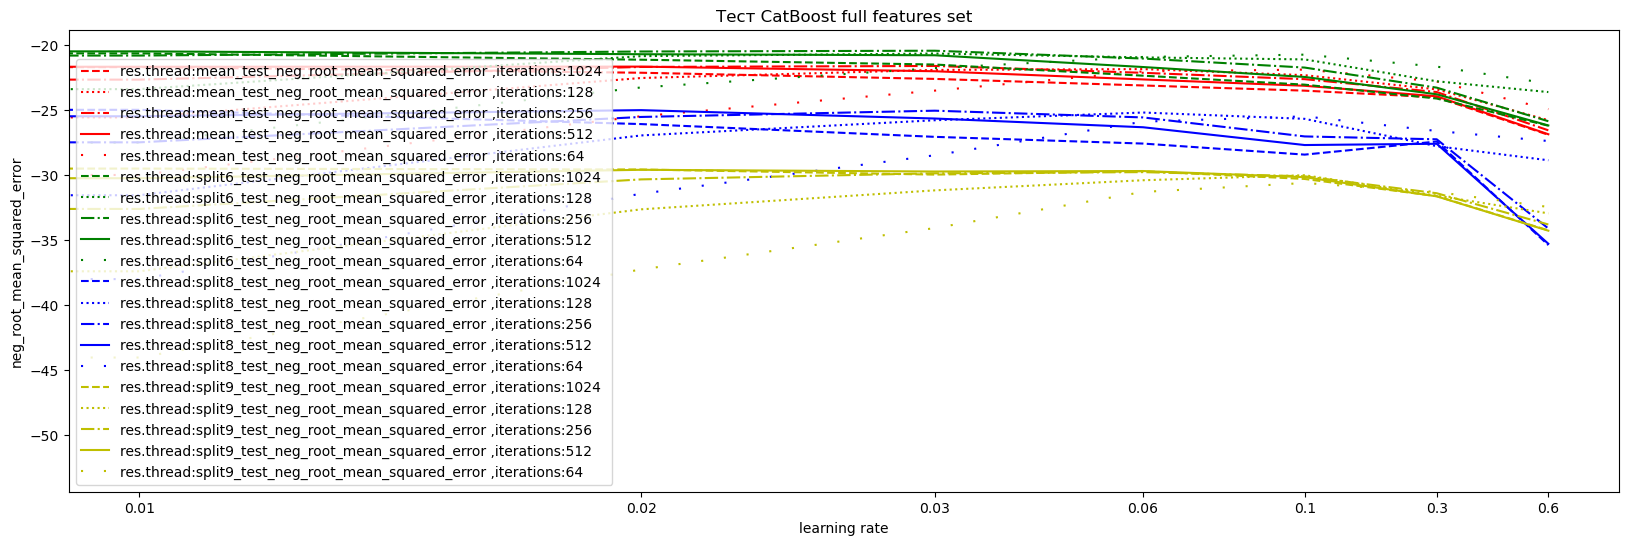

In [40]:
cbst.plot()

К сожалению, финальные серии предсказывающие крайние результаты (желтые , split_9) дают гораздо худший результат , чем ранние (split_6). Я это связываю с тем, что характер предсказываемой кривой в августе несколько изменился.

Характер кривых скоринга  все же не меняется и максимумы так же на .03-.1  с максимальным числом оценщиков,
 так что выбор лучшей модели не меняется .
 
Возникает вопрос -  как лучше отбирать тренировочную выборку для подбора гиперпараметров ? 
Возможно нужно "расширять" тренировочное окно назад и сравнивать результаты, но простого сопсоба сделать это я не нашел. 

#### Тест на сокращенном наборе признаков 

In [41]:
%%time
cbsts = TestModel(CatBoostRegressor(logging_level='Silent',cat_features=cat_cols),
                  params=   {'cv': tscv,'title':'CatBoost short features set'} )
cbsts.cross_validate(param_grid,Xs_tr,y_tr)

CPU times: user 3min 9s, sys: 47.7 s, total: 3min 56s
Wall time: 8min 6s


{'iterations': 512, 'learning_rate': 0.03}

In [42]:
cbsts.check_best(Xs_tr,y_tr,Xs_te,y_te)

RMSE: 39.33479419995591 	
r2_score: 0.5539416683777283 	


In [43]:
cbsts.parse_result()

mean_test_neg_root_mean_squared_error                        \
iterations                                     1024        128        256   
learning_rate                                                               
0.003                                    -26.092454 -34.553993 -31.747190   
0.01                                     -24.572876 -29.132383 -26.685143   
0.02                                     -24.563824 -26.840074 -25.151097   
0.03                                     -24.656425 -26.163271 -24.781477   
0.06                                     -24.911738 -25.914599 -24.663095   
0.1                                      -25.558553 -26.346499 -24.954026   
0.3                                      -26.651629 -27.705633 -25.621857   
0.6                                      -28.798183 -28.854625 -27.679638   

                                     
iterations           512         64  
learning_rate                        
0.003         -28.575245 -36.693818  
0.01          -25.159753 -32.304226  
0.02          -24.612410 -29.089362  
0.03          -24.492204 -27.574456  
0.06          -24.773030 -26.226288  
0.1           -25.198228 -25.892348  
0.3           -26.281529 -26.780536  
0.6           -28.318766 -27.963959

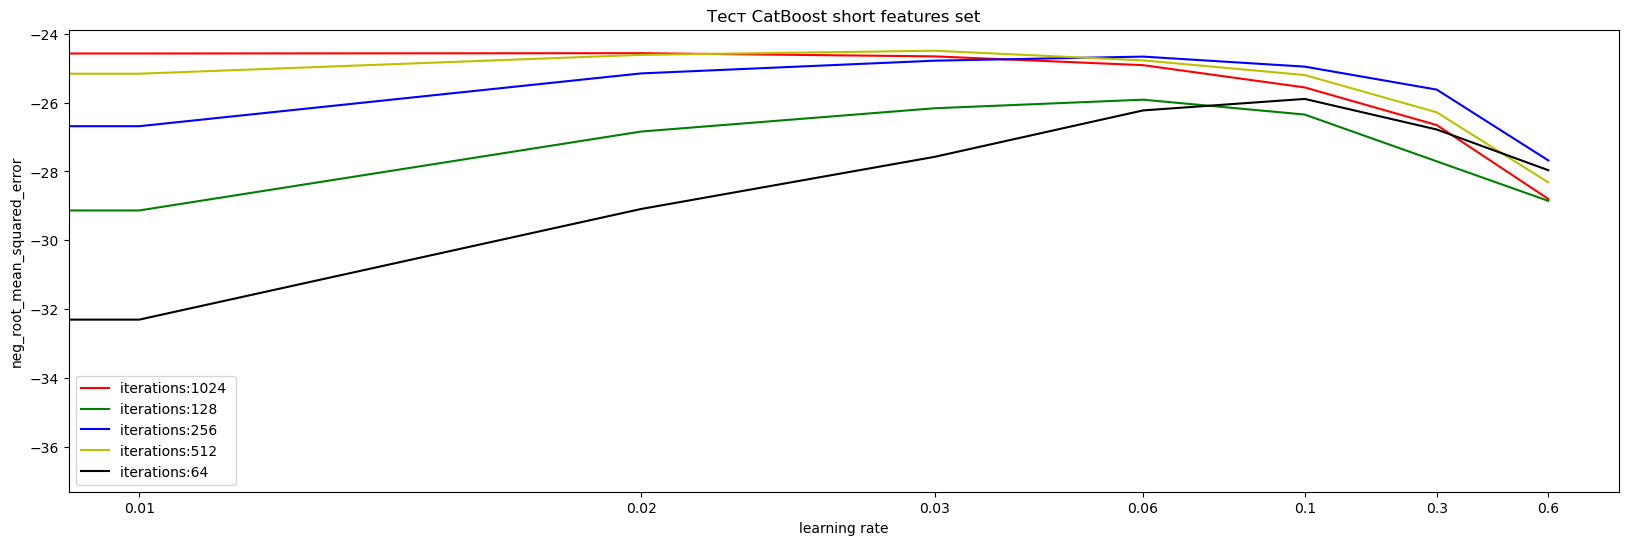

In [44]:
cbsts.plot()

Выбор оптимальной модели тот же, но результаты несколько хуже.  
Так что дополнительные признаки все же полезны

#### LGBM Test

In [45]:
debug_grid = {
    'iterations': [64,128],
    'learning_rate': [.1,.03,.01,.003]
}

test_grid = {
    'boosting': ['gbdt','dart','goss'],
    'iterations': [64],
    'learning_rate': [.6,.3,.1,.03,.01,.003]
}
param_grid = test_grid

In [46]:
%%time
lgbm = TestModel(LGBMRegressor(verbose=-1),
                  params=   {'cv': tscv,'title':'LGBM'} )
lgbm.cross_validate(param_grid,X_tr,y_tr)

CPU times: user 8.71 s, sys: 34.2 ms, total: 8.75 s
Wall time: 8.57 s


{'boosting': 'goss', 'iterations': 64, 'learning_rate': 0.03}

In [47]:
lgbm.check_best(X_tr,y_tr,X_te,y_te)

RMSE: 39.20932465084289 	
r2_score: 0.5567827904908103 	


In [48]:
lgbm.parse_result()

mean_test_neg_root_mean_squared_error                      
boosting                                       dart       gbdt       goss
learning_rate                                                            
0.003                                    -53.720918 -33.184557 -33.184557
0.01                                     -46.155430 -25.752845 -25.752845
0.03                                     -33.948261 -22.210904 -22.033981
0.1                                      -23.883873 -22.675172 -22.264789
0.3                                      -22.606317 -23.619364 -24.449815
0.6                                      -23.335032 -25.299808 -31.339833

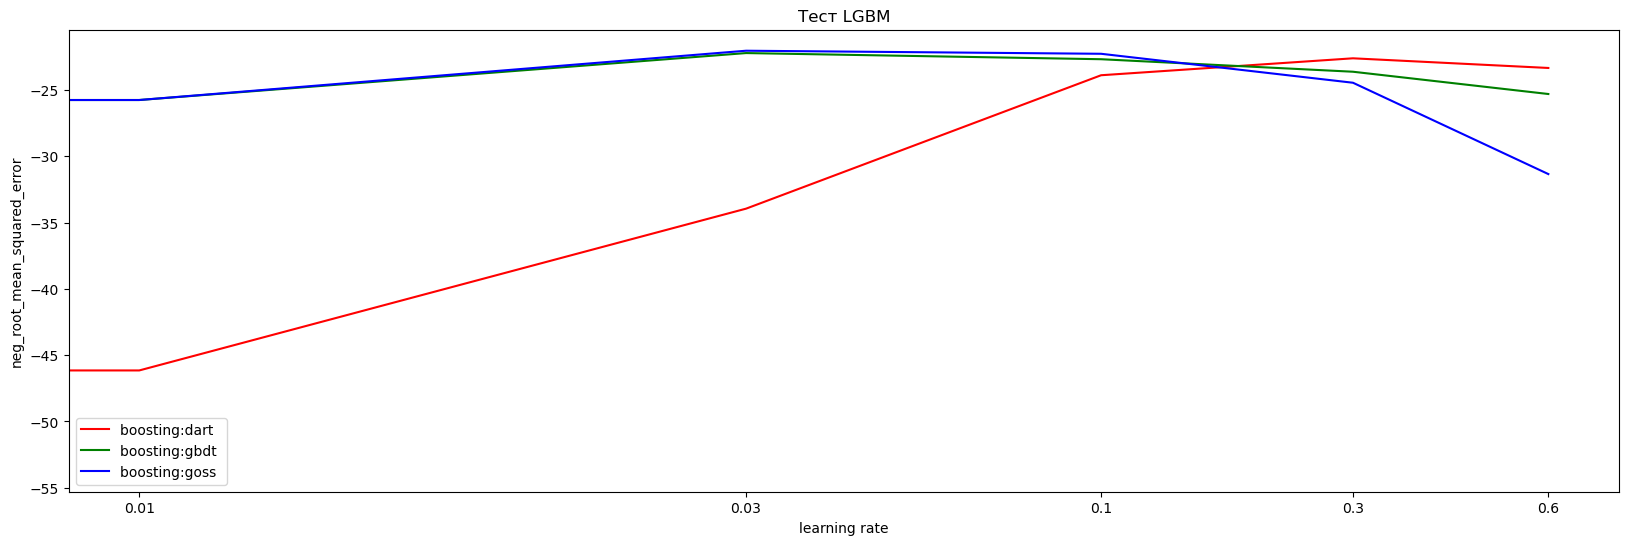

In [49]:
lgbm.plot()

Модель LGBM показала несколько худший результат , чем CatBoost.  
Оптимальные скорости обучения так же около .03-.1, хотя на неоптимальных падение качества обучения идет быстрее , чем у CatBoost  
В качестве оптимальной модели выбрана лучшая модель Catboost

### ВЫВОДЫ

* Количество заказов монотонно растет по неделям , общий рост за полгода - примерно 20% 
* В количестве заказов наблюдаются недельные и суточные колебания
* Максимальное количество заказов в понедельник и пятницу , минимальное - во вторник и воскресенье
* В течение суток максимумы заказов в полночь и в часы пик , минимумы - под утро
* Моделирование позволят предсказывать количество закзов в час со среднеквадратичным отклонением 40
* Лучшая предказывающая модель - Catboost, при  предсказании нужно учитывать час и день недели, важно также колчиество заказов неделю назад и среднее за две недели  